In [0]:
!pip install eli5

In [0]:
!pip install pdpbox

In [0]:
!pip install shap

In [0]:
!pip install category_encoders

In [0]:
import eli5
import pdpbox
import shap
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [0]:
# Download and join data into a dataframe
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    #daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()

In [0]:
import numpy as np

def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))

    
    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10
    
    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])

    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry_day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X
  
daily = jake_wrangle(daily)
daily = daily.reset_index().rename(columns={'index':'date'})

In [0]:
#Do some more feature engineering:

#is it the weekend:

def weekend(X):
  X = X.copy()
  X['wknd'] = (X.Sat == 1) | (X.Sun == 1)
  X['wknd'] = X['wknd'].astype('int')
  return X

daily = weekend(daily)

#Cold and rainy/snowy:

def cold_precip(X):
  X = X.copy()
  X['cold_precip'] = (X['Temp (C)'] < 10 ) & (X.dry_day ==0)
  X['cold_precip'] = X['cold_precip'].astype('int')
  return X

daily = cold_precip(daily)

#create bool col for extreme temp (below freezing or above 86 F (30C)
def extreme_temp(X):
  X = X.copy()
  X['extreme_temp'] = (X['Temp (C)'] < 0) | (X['Temp (C)'] > 30) 
  X['extreme_temp'] = X['extreme_temp'].astype('int')
  return X

daily = extreme_temp(daily)

#Make col for length of prior consecutive rain days as well as col for a sunny wknd that follows a rainy wknd:
def rain_streak(X):
  X = X.copy()
  X['rain_streak_count'] = 0
  for i in range(1, len(X)):
    X.at[i, 'rain_streak_count'] = 0 if (X.at[i, 'dry_day'] == 1) else (X.at[i-1, 'rain_streak_count'] + 1)
  X['rain_streak_now_sunny'] = (X.rain_streak_count.shift(1) > 1) & (X.dry_day == 1)
  X['rain_streak_now_sunny'] =  X['rain_streak_now_sunny'].astype('int')
  X['rain_streak_now_sunny_length'] =  X['rain_streak_now_sunny'].astype('int') * X['rain_streak_count'].shift(1)
  X['dry_wknd_day_and_rained_last_wknd'] = (X.dry_day==1) & ((X.Sat == 1) & (X.dry_day.shift(7) == 0 & (X.dry_day.shift(6) == 0))) | ((X.Sun == 1) & (X.dry_day.shift(8) == 0) & (X.dry_day.shift(7) == 0) & (X.dry_day.shift(1) == 0))
  X['dry_wknd_day_and_rained_last_wknd'] = X['dry_wknd_day_and_rained_last_wknd'].astype('int')
  X = X.drop(index=X.index[0]).reset_index(drop=True)
  return X

daily = rain_streak(daily)

def convert_date(X):
  X = X.copy()
  def get_month(x):
    return x.month
  def get_day(x):
    return x.day
  X['month'] = X['date'].apply(get_month)
  X['day'] = X['date'].apply(get_day)
  return X

daily = convert_date(daily)

#Fix some wacky values in the SNOW col:
daily = daily.replace(-9999, 0)

In [75]:
daily.head()

,date,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry_day,annual,wknd,cold_precip,extreme_temp,rain_streak_count,rain_streak_now_sunny,rain_streak_now_sunny_length,dry_wknd_day_and_rained_last_wknd,month,day
0,2012-10-04,3475.0,0.0,0,0,18.9,8.3,65,3521.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,13.60,1,0.002740,0,0,0,0,0,0.0,0,10,4
1,2012-10-05,3148.0,0.0,0,0,21.7,8.9,57,3475.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,15.30,1,0.005479,0,0,0,0,0,0.0,0,10,5
2,2012-10-06,2006.0,0.0,0,0,23.9,7.8,51,3148.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,15.85,1,0.008219,1,0,0,0,0,0.0,0,10,6
3,2012-10-07,2142.0,0.0,0,0,23.9,7.8,13,2006.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,15.85,1,0.010959,1,0,0,0,0,0.0,0,10,7
4,2012-10-08,3537.0,0.0,0,0,21.1,7.8,19,2142.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.987503,14.45,1,0.013699,0,0,0,0,0,0.0,0,10,8


# ASSIGNMENT

In a clean notebook, using the **Seattle Bicycle Weather** dataset, make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

In [0]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [0]:
#Split into train/test:

test = daily[-100:]
train = daily[:-100]
train.shape, test.shape

target = 'Total'
X_train = train.drop(columns=[target, 'date'])
y_train = train[target]

X_test = test.drop(columns=[target, 'date'])
y_test = test[target]

In [78]:
y_train.head()

0    3475.0
1    3148.0
2    2006.0
3    2142.0
4    3537.0
Name: Total, dtype: float64

In [79]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators' : [100, 200, 500],
    'max_depth': [2,3,5,10,50]
}

search = RandomizedSearchCV(
    XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions= param_distributions,
    n_iter=8,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print('Cross-Validation MAE:', search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   11.9s finished


Cross-Validation MAE: -264.2724312795162


In [80]:
from sklearn.metrics import mean_absolute_error

best = search.best_estimator_
y_pred = best.predict(X_test)
print('Test MAE:', mean_absolute_error(y_test, y_pred))

Test MAE: 227.77776306152344


##Feature Importances

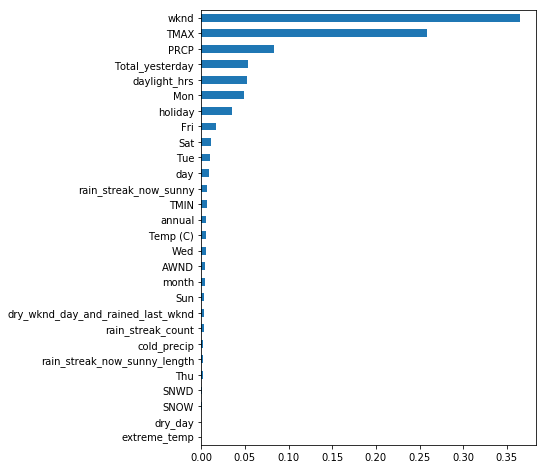

In [81]:
from matplotlib import pyplot as plt

figsize = (6,8)

importances = pd.Series(best.feature_importances_, X_train.columns)


plt.figure(figsize=figsize)
importances.sort_values().plot.barh()

##Permutation Importances


In [82]:
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_test, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [83]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
641.4955 ± 3.2226,wknd
112.3072 ± 2.9494,Total_yesterday
82.4046 ± 35.7262,TMAX
66.8126 ± 21.8464,PRCP
58.5115 ± 3.5358,Fri
33.7711 ± 3.1641,holiday
21.3979 ± 8.3371,Tue
21.1269 ± 12.1749,TMIN
13.9495 ± 8.5245,Sat
7.7099 ± 8.6438,Mon


In [84]:
print('Shape before removing features', X_train.shape)

mask = permuter.feature_importances_ > 0

features = X_train.columns[mask]
X_train = X_train[features]
X_test = X_test[features]

print('Shape after removing features: ', X_train.shape)

Shape before removing features (963, 28)
Shape after removing features:  (963, 15)


In [85]:
param_distributions = {
    'n_estimators' : [100, 200, 500],
    'max_depth': [2,3,5,10,50]
}

search = RandomizedSearchCV(
    XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions= param_distributions,
    n_iter=8,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print('Cross-Validation MAE w/ permuted features: ', search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.2s finished


Cross-Validation MAE w/ permuted features:  -267.2860769210451


In [86]:
best = search.best_estimator_
y_pred = best.predict(X_test)
print('Test MAE w/ permuted features: ', mean_absolute_error(y_test, y_pred))

Test MAE w/ permuted features:  247.48753051757814


##Partial Dependence Plot

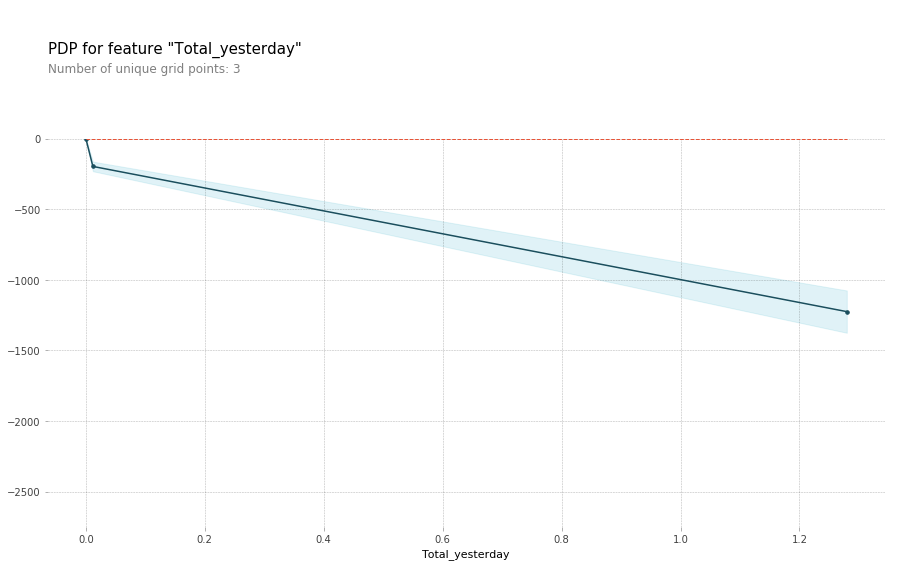

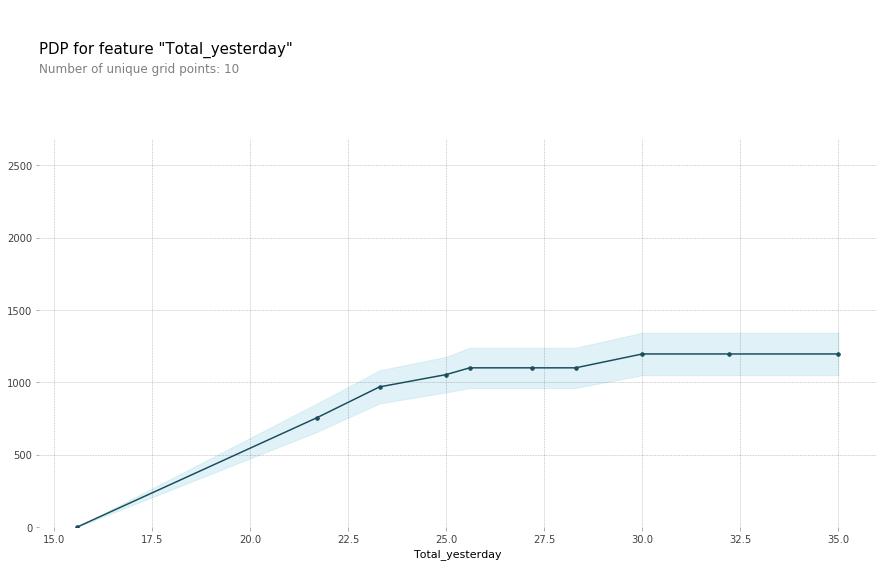

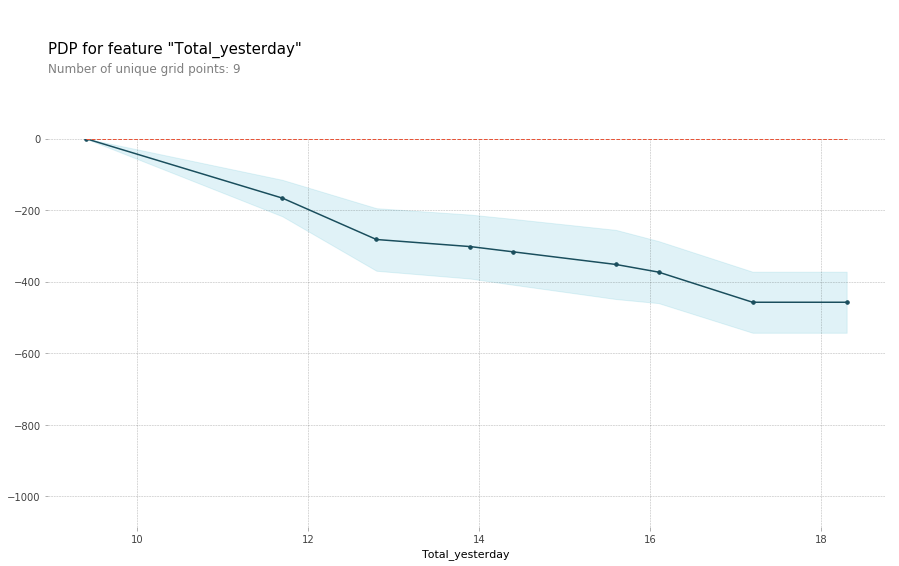

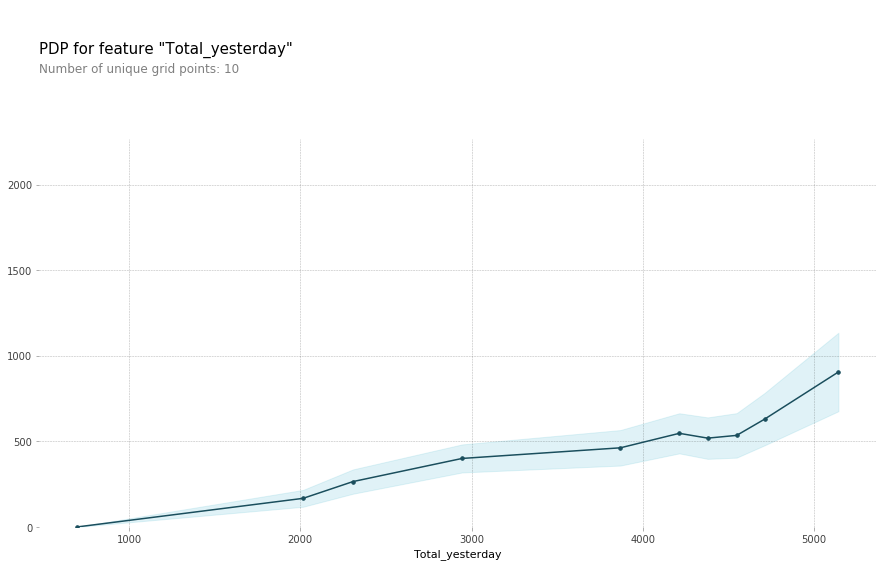

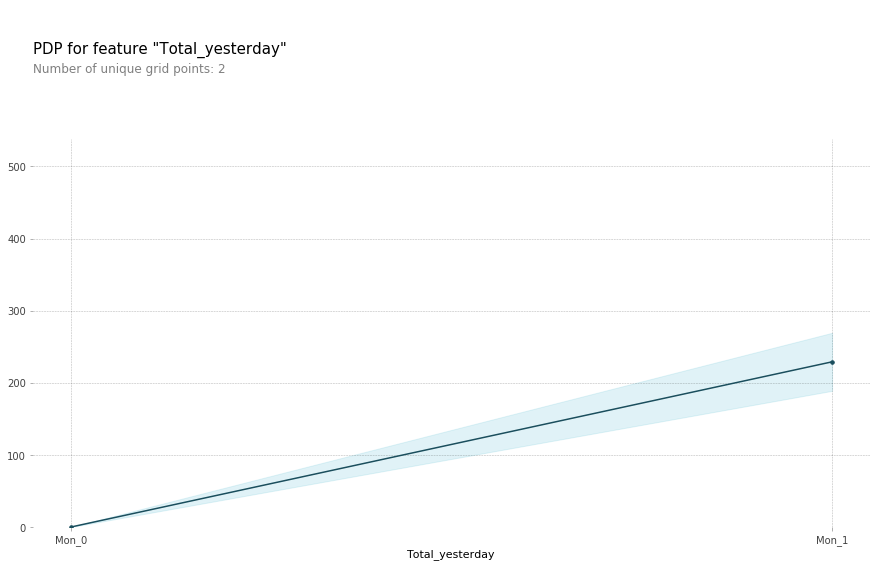

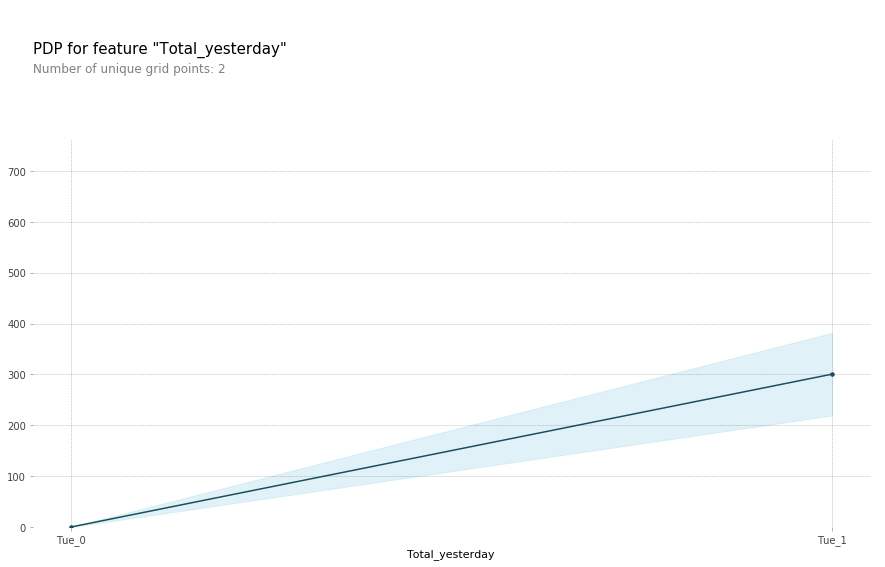

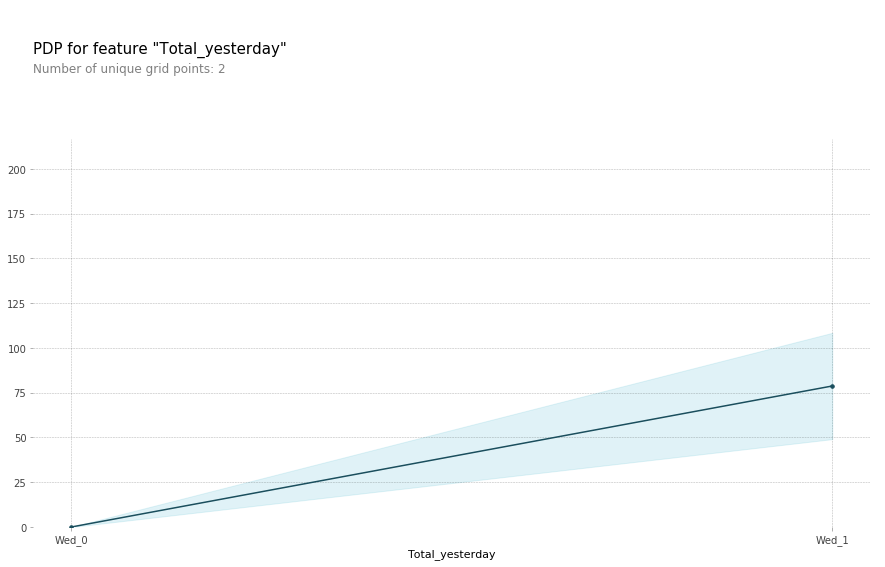

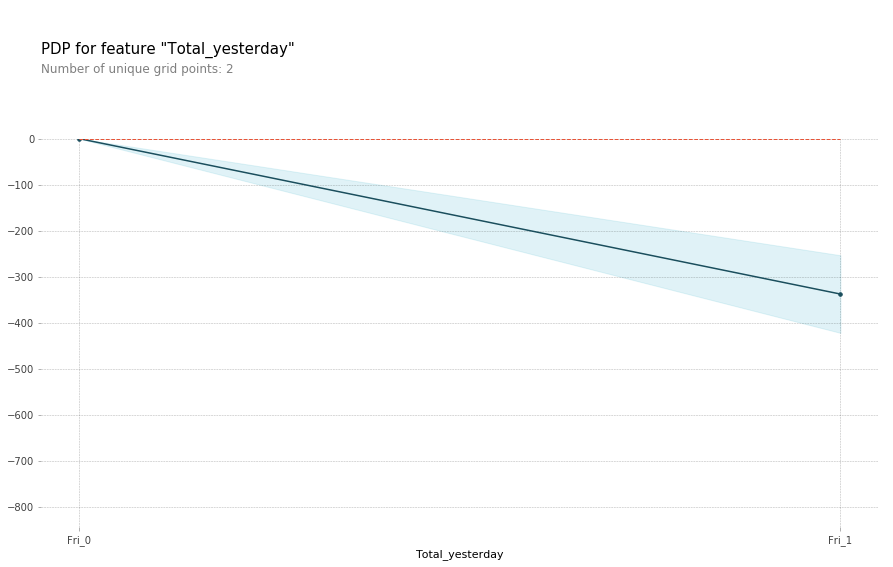

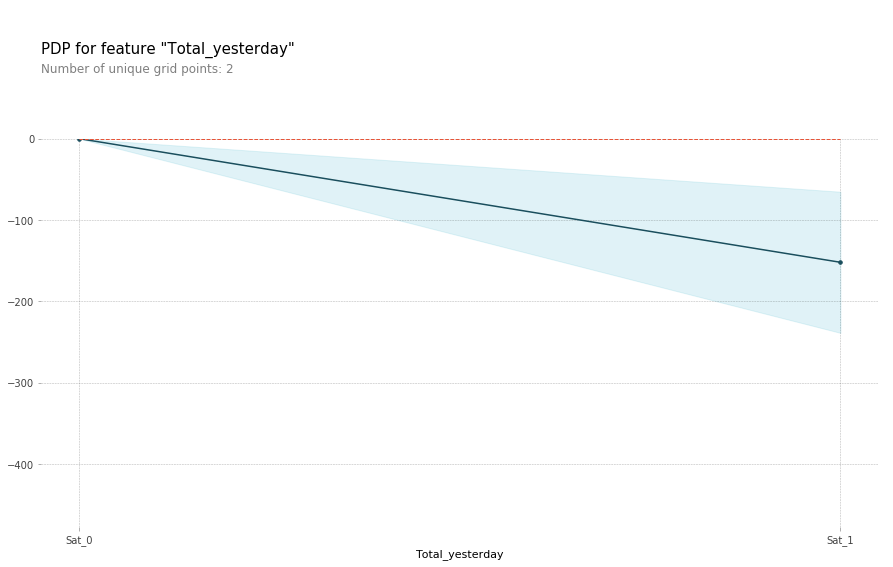

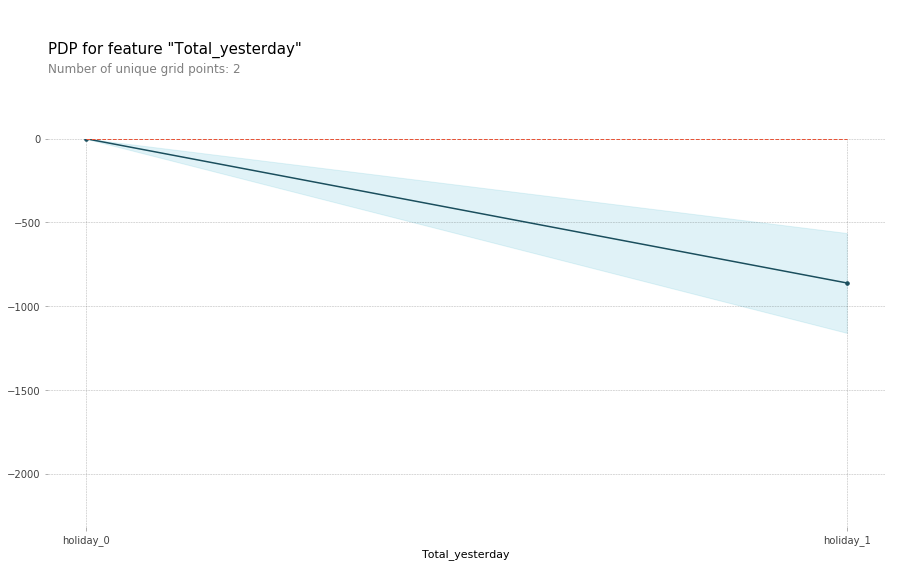

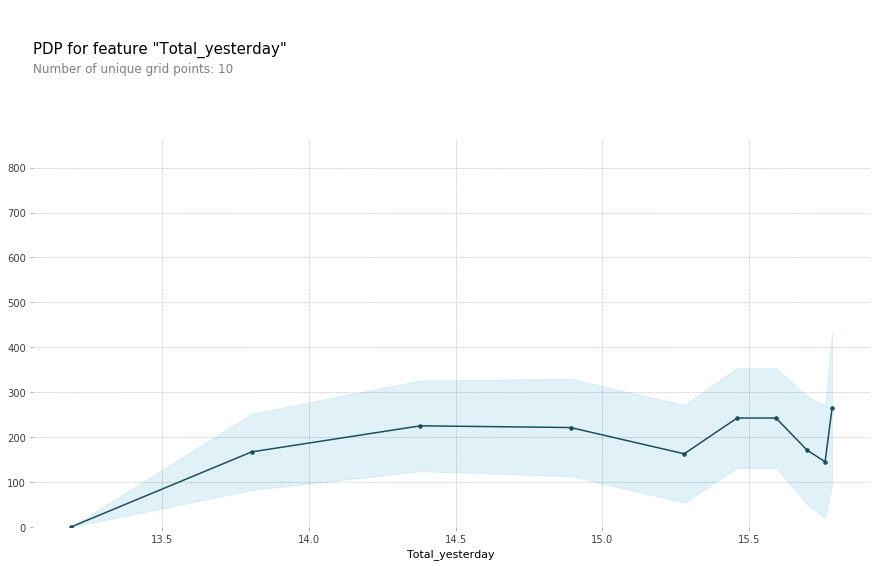

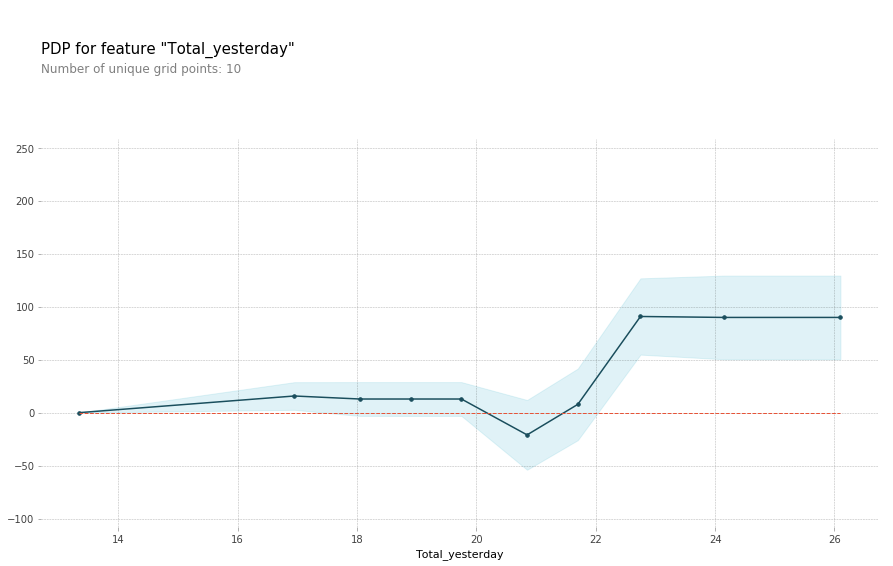

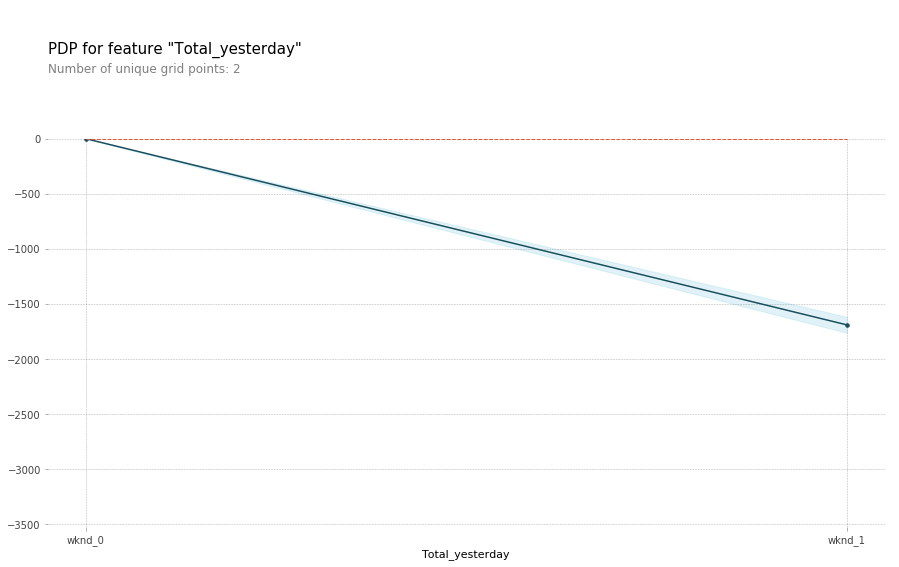

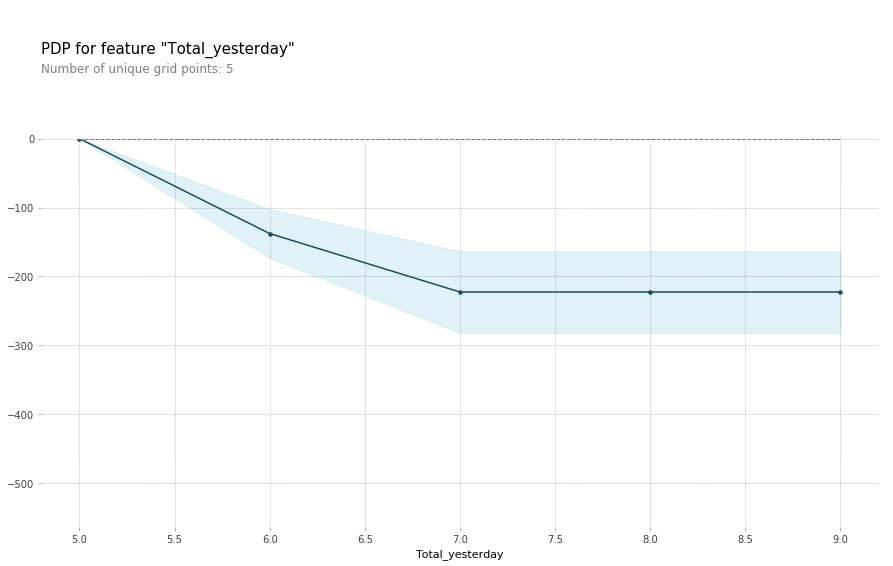

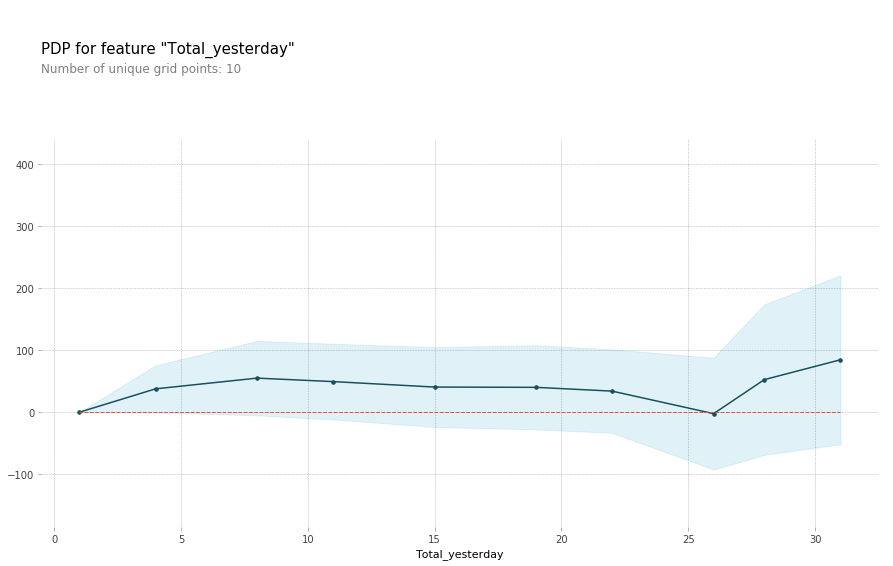

In [110]:
from pdpbox.pdp import pdp_isolate, pdp_plot

for f in X_test.columns:
  
  isolated = pdp_isolate(
      model = best,
      dataset = X_test,
      model_features = X_test.columns,
      feature = f
  )

  pdp_plot(isolated, feature_name = feature);

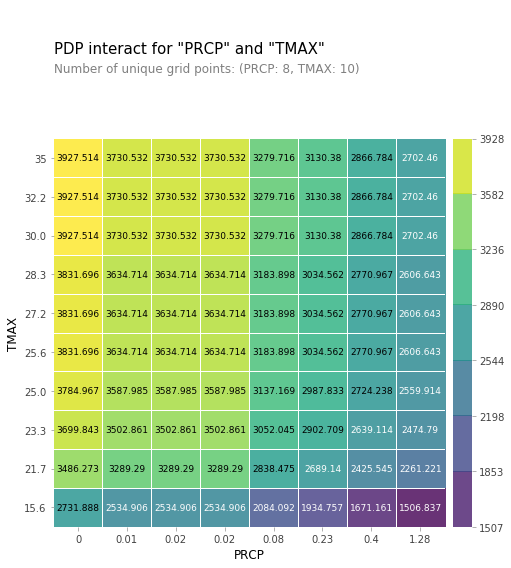

In [109]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features= ['PRCP', 'TMAX']

interaction = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    features=features,
    num_grid_points=[50, 10]
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

##Shapley Values

In [98]:
y_pred = best.predict(X_test)
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
preds['abs_error'] = abs(preds['y_test'] - preds['y_pred'])
preds.head(10)

,y_test,y_pred,abs_error
963,1737.0,2018.561279,281.561279
964,4254.0,4040.317871,213.682129
965,4771.0,4746.356934,24.643066
966,5142.0,4725.056152,416.943848
967,4548.0,4737.555664,189.555664
968,2308.0,2905.502930,597.502930
969,2251.0,2865.806396,614.806396
970,2989.0,3153.587158,164.587158
971,3078.0,3816.128906,738.128906
972,3658.0,4324.442871,666.442871


In [0]:
most_accurate_pred_index = preds.sort_values('abs_error').head(1).index[0]
least_accurate_pred_index = preds.sort_values('abs_error').tail(1).index[0]

In [95]:
#Shap Tree Explainer for our most accurate prediction
shap.initjs()

data_for_prediction = X_test[X_test.index == most_accurate_pred_index]
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [96]:
#Shap Tree Explainer for our least accurate prediction
shap.initjs()

data_for_prediction = X_test[X_test.index == least_accurate_pred_index]
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)